In [1]:
import pickle
import calendar
import os
import regex as re
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import datetime
from dateutil import parser
from itertools import compress

from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils import shuffle

from xgboost import XGBRegressor, DMatrix

import warnings

warnings.filterwarnings("ignore")

sns.set(rc={"figure.figsize": (11.7, 8.27)})

In [3]:
dat = pd.read_csv("../Data/cleaned_data.csv")
dat = dat.loc[:, "Access":]

dat = dat.rename(columns={'Impression (000)': 'Impressions'})

dat["Date Aired"] = pd.to_datetime(dat["Date Aired"]).dt.date
dat["Time Aired"] = pd.to_datetime(dat["Time Aired"], format="%H:%M:%S").dt.time

hours = [x.hour for x in dat['Time Aired'].values]
dat["Hours"] = hours

In [4]:
months = [int(x.strftime('%m')) for x in dat['Date Aired'].values]
dat['Month'] = months
bins = [1, 3, 6, 9, 12]
labels = ['Q1', 'Q2', 'Q3', 'Q4']
dat['Quarter'] = pd.cut(dat['Month'], bins, labels=labels)

In [5]:
split_access = dat['Access'].str.split('(^[0-9]{2})|(^[A-Z]{2})')

creative_list = []
for x in split_access:
    if x[1] is None:
        creative_list.append(x[2])
    else:
        creative_list.append(x[3])
        
dat['creative'] = creative_list

In [6]:
outliers = pd.read_pickle('outlier_stations.pickle')
outlier_df = pd.DataFrame(outliers).reset_index()
outlier_df['bins'] = pd.qcut(outlier_df['Station ID'], q=5, labels = [1, 2, 3, 4, 5])
outlier_df.drop(0, axis=1, inplace=True)

outlier_stations = list(outliers.index.get_level_values('Station ID'))[0:12]
dat['is_outlier'] = np.where(np.isin(dat['Station ID'], outlier_stations), 1, 0)
dat = dat.join(outlier_df, on='Station ID', how='left', rsuffix='_')
dat['bins'] = dat['bins'].replace(np.nan, 0)

dat = pd.concat([dat, pd.get_dummies(dat['bins'])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat['creative'])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["Estimate"])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["Market"])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["DOW"])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat['Quarter'])], axis=1)
dat = pd.concat([dat, pd.get_dummies(dat["daypart"])], axis=1)

In [7]:
dat = dat.rename(columns={0.0: 'bin_0', 1.0: 'bin_1', 2.0: 'bin_2', 3.0: 'bin_3', 4.0: 'bin_4', 5.0: 'bin_5'})
dat = dat.rename(columns=lambda x: x.strip().replace(' ', '_'))

dat = pd.concat([dat, pd.get_dummies(dat['Hours'])], axis=1)
dat = dat.rename(columns={0: 'midnight', 1: 'one_am', 2: 'two_am', 3: 'three_am', 4: 'four_am', 5: 'five_am',
                          6: 'six_am', 7: 'seven_am', 8: 'eight_am', 9: 'nine_am', 10: 'ten_am', 11: 'eleven_am',
                          12: 'noon', 13: 'one_pm', 14: 'two_pm', 15: 'three_pm', 16: 'four_pm', 17: 'five_pm',
                          18: 'six_pm', 19: 'seven_pm', 20: 'eight_pm', 21: 'nine_pm', 22: 'ten_pm', 23: 'eleven_pm'})
dat.columns

Index(['Access', 'DMA', 'Date_Aired', 'Estimate', 'GRP', 'Impressions',
       'Length', 'Market', 'Media', 'Spot_Cost', 'Spot_Type', 'Station_ID',
       'Time_Aired', 'DOW', 'daypart', 'Hours', 'Month', 'Quarter', 'creative',
       'is_outlier', 'Station_ID_', 'bins', 'bin_0', 'bin_1', 'bin_2', 'bin_3',
       'bin_4', 'bin_5', 'BP', 'DC', 'DE', 'DP', 'GD', 'GX', 'PL', 'PM', 'PN',
       'PT', 'SR', 'SV', 'TN', 'VE', 'Q119', 'Q219', 'Q319', 'Q419', 'Cable',
       'DirecTV', 'Dish_Network', 'National_Network', 'Over-the-top_content',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday', 'Q1', 'Q2', 'Q3', 'Q4', 'Daytime', 'Early_Fringe',
       'Late_Fringe', 'Late_Night', 'Morning', 'Overnight', 'Primetime',
       'midnight', 'one_am', 'two_am', 'three_am', 'four_am', 'five_am',
       'six_am', 'seven_am', 'eight_am', 'nine_am', 'ten_am', 'eleven_am',
       'noon', 'one_pm', 'two_pm', 'three_pm', 'four_pm', 'five_pm', 'six_pm',
       'seven_

In [8]:
def active_flag(row):    
    flag_list = [10, 280, 252, 55]

    if row['Station_ID'] in flag_list and np.isnan(row['Impressions']):
        return(1)
    else:
        return(0)
    
dat['active_flag'] = dat.apply(active_flag, axis=1)

In [9]:
dat.to_csv('../Data/dat_features.csv')

In [177]:
unseen = dat[(dat.Impressions.eq(0.0)) & (dat.GRP.eq(0.0)) | (dat.active_flag.eq(1))]
training = dat[dat.Impressions > 0.0]

In [13]:
labels = [
        "Length",
        "Spot_Cost",
        "Cable", 
        "DirecTV",
        "Dish_Network",
        "National_Network",
        "Over-the-top_content",
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
        'bin_1', 'bin_2',                
        'bin_3', 'bin_4', 'bin_5',
        'midnight', 'one_am', 'two_am', 'three_am', 'four_am', 
        'five_am', 'six_am', 'seven_am', 'eight_am', 'nine_am', 
        'ten_am', 'eleven_am', 'noon', 'one_pm', 'two_pm',
        'three_pm', 'four_pm', 'five_pm', 'six_pm', 'seven_pm', 
        'eight_pm', 'nine_pm', 'ten_pm', 'eleven_pm'
    ]

X = training.loc[:,labels]
y = training.loc[:, "Impressions"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

NameError: name 'training' is not defined

In [181]:
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

## Ridge CV Tuning

In [182]:
rcv = RidgeCV(alphas=[1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10], normalize=True)
rcv.fit(X_train, y_train)
rcv.score(X_train, y_train)

0.22415290196870274

In [169]:
rcv.get_params()

{'alphas': array([1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03,
        1.e-02, 1.e-01, 1.e+00, 1.e+01]),
 'cv': None,
 'fit_intercept': True,
 'gcv_mode': None,
 'normalize': True,
 'scoring': None,
 'store_cv_values': False}

In [170]:
preds_rcv = rcv.predict(X_test)

## Ridge regression with SelectFromModel

In [171]:
mse_list = []
rmse_list = []
score_list = []
a_list = []
for a in [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]:
    ridge = Ridge(alpha=a, normalize=True, solver='sag', random_state=1234)
    
    ridge.fit(X_train, y_train)
    preds = ridge.predict(X_test)
    score_list.append(ridge.score(X_test, y_test))
    mse_list.append(MSE(y_test, preds))
    rmse_list.append(np.sqrt(MSE(y_test, preds)))
    a_list.append(a)

In [172]:
ridge_results = pd.DataFrame(list(zip(a_list, score_list, mse_list, rmse_list)), 
                             columns = ['Alpha', 'R2', 'MSE', 'RMSE'])

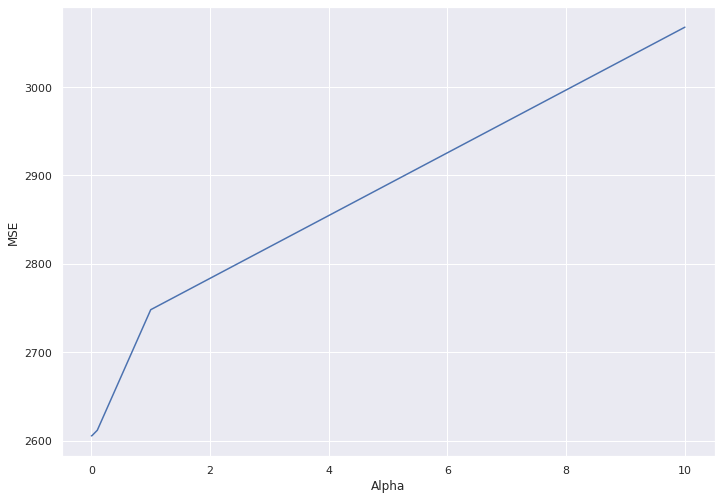

In [173]:
line = sns.lineplot('Alpha', 'MSE', data=ridge_results)
plt.show()

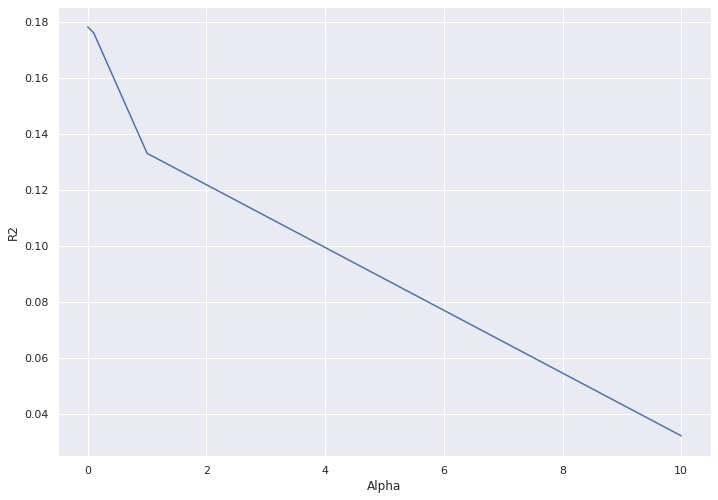

In [174]:
line = sns.lineplot('Alpha', 'R2', data=ridge_results)
plt.show()

In [175]:
rcv_list = [rcv.alpha_, rcv.score(X_test, y_test), MSE(y_test, rcv.predict(X_test)), np.sqrt(MSE(y_test, rcv.predict(X_test)))]
rcv_results = pd.DataFrame(rcv_list).transpose()
rcv_results

0         1          2          3
0  0.1  0.175976  2611.7051  51.104844

In [176]:
ridge_results[ridge_results.MSE == ridge_results.MSE.min()]

Alpha        R2          MSE       RMSE
0  1.000000e-10  0.177985  2605.339225  51.042524

In [165]:
selector_ridge = SelectFromModel(estimator=Ridge(alpha=1.000000e-10, normalize=True)).fit(X_train, y_train)
selector_ridge.get_support()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False,  True, False,  True,  True,  True, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False])

In [166]:
selected_labels = list(compress(labels, list(selector_ridge.get_support())))
selected_labels

X_adj = training.loc[:,selected_labels]
X_train_adj, X_test_adj, y_train_adj, y_test_adj = train_test_split(X_adj, y, test_size=0.25)

#### Ridge Regression with selected predictors

In [167]:
ridge_adjusted = Ridge(alpha=1.000000e-10, normalize=True)
ridge_adjusted.fit(X_train_adj, y_train_adj)
preds = ridge_adjusted.predict(X_test_adj)

print(ridge_adjusted.score(X_test_adj, y_test_adj))
print(MSE(y_test_adj, preds))

0.21159280634672784
1611.631719477657


In [168]:
print(np.sqrt(MSE(y_test_adj, preds)))

40.14513319790653
